# Computing Adversarial Flows

In this notebook we load a trained model and compute the FGSM and minimizing movement iterations.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import torch
from flows import adv_loss, get_cbo, FGSM, MinMove
from plots import plot_rect_budget, plot_fun

# Define Device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Operating on device: ' + str(device))

Operating on device: cuda


# Load model and define loss

In [3]:
from model import get_two_moons_model
act_fun = 'GeLU'
model = get_two_moons_model(act_fun=act_fun)
model.load_state_dict(torch.load('data-weights/two_moons_'+ act_fun + '.pt'))
if act_fun == 'GeLU':
    x0 = torch.tensor([0.45,0.3], device=device)[None,:]
    epsilon = 0.25
else:
    x0 = torch.tensor([0.1,0.55], device=device)[None,:]
    epsilon = 0.2
model.eval()
model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): GELU(approximate='none')
  (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): GELU(approximate='none')
  (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): GELU(approximate='none')
  (8): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=20, out_features=1, bias=True)
  (10): Sigmoid()
)

# Define initial value, budget and loss

In [4]:
oup = model(x0).item()
y = 1*(oup>0.5)
print('Output on original point: ' + str(oup))
print('Class: ' +str(y))
E = adv_loss(model, y=y)

Output on original point: 0.7375566363334656
Class: 1


# Run FGSM an minimizing movement

In [5]:
taus = [epsilon, epsilon*0.5, epsilon*0.1, 1e-3]
stepsizes = [1, 3, 50, 100]

def run_iterations(x0, taus, stepsizes = None, T=1):
    stepsizes = [int(T/tau) for tau in taus] if stepsizes is None else stepsizes
    print('Computing for taus: ' + str(taus))
    print('Computing with stepsizes: ' + str(stepsizes))
    hs = {}
    opts = [{'opt':FGSM, 'kwargs':{}}, {'opt':MinMove, 'kwargs':{'max_inner_it':30, 'N':30, 'alpha':10**8}}]
    T = 1

    for o in opts:
        for i,tau in enumerate(taus):
            tau = round(tau,3)
            opt = o['opt'](x0, E, epsilon=epsilon, tau=tau, **o['kwargs'])
            opt.optimize(max_iter=stepsizes[i])
            print('Finished for opt = ' + opt.__class__.__name__ + ', tau = ' + str(tau))
            hs[opt.__class__.__name__ + str(tau)] = (torch.stack(opt.hist).numpy(), tau)
    print(30*'-')
    print('Finished all.')
    return hs
    
hs = run_iterations(x0, taus)

Computing for taus: [0.25, 0.125, 0.025, 0.001]
Computing with stepsizes: [4, 8, 40, 1000]
Finished for opt = FGSM, tau = 0.25
Finished for opt = FGSM, tau = 0.125
Finished for opt = FGSM, tau = 0.025
Finished for opt = FGSM, tau = 0.001
Finished for opt = MinMove, tau = 0.25
Finished for opt = MinMove, tau = 0.125
Finished for opt = MinMove, tau = 0.025
Finished for opt = MinMove, tau = 0.001
------------------------------
Finished all.


# Plotting

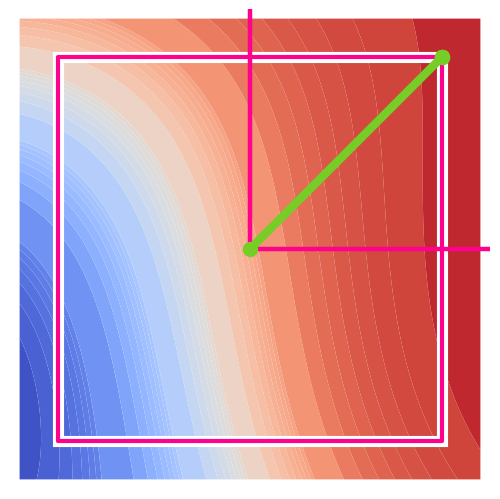

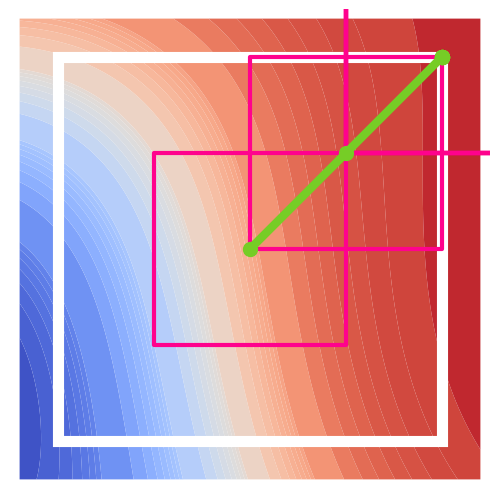

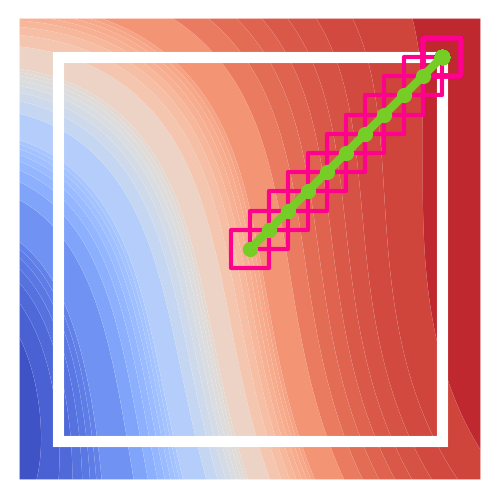

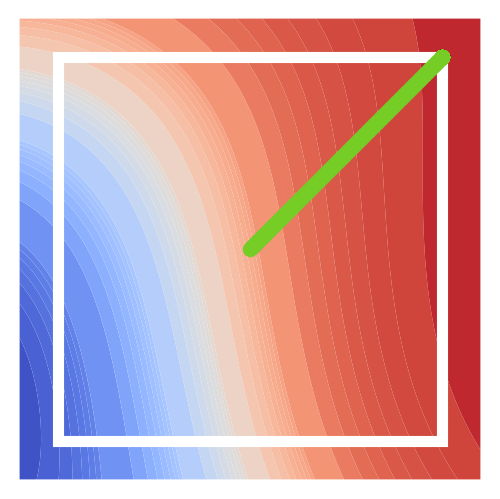

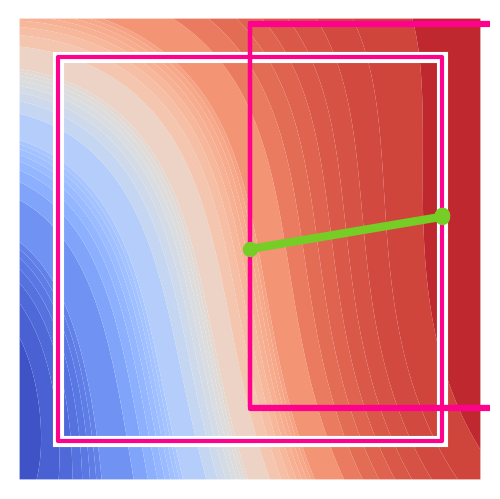

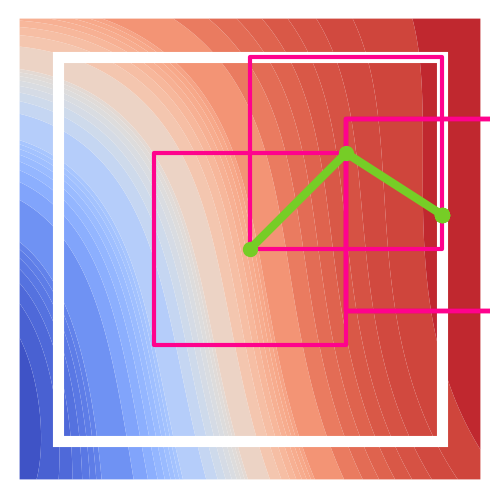

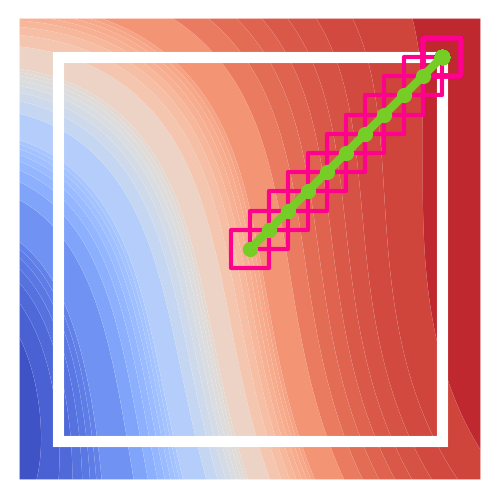

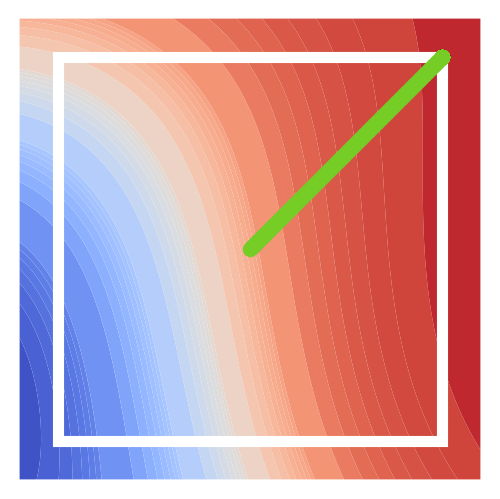

In [6]:
from matplotlib import ticker

def plot_iterations(hs, save_fig=False, colorbar=False):
    colors = ['xkcd:apple green', 'xkcd:hot pink', 'xkcd:hot pink', 'xkcd:hot pink', 'xkcd:seafoam', 'xkcd:slate blue', 'xkcd:light yellow']
    for k in hs.keys():
        x, tau = hs[k]
        fig, ax = plt.subplots()
        ax.axis('off')
        ax.axis('square')
        ax.set_xlim(x[0,0,0]-1.25*epsilon, x[0,0,0] + 1.25*epsilon)
        ax.set_ylim(x[0,0,1]-1.25*epsilon, x[0,0,1] + 1.25*epsilon)
        xyrange = [(x[0,0,i].item() - 1.2 *epsilon, x[0,0,i].item() + 1.2 *epsilon) for i in [0,1]]
        cf = plot_fun(ax, E, cmap='coolwarm', device=device, xrange= xyrange[0], yrange=xyrange[1], locator=ticker.LogLocator(numticks=50, subs='auto'),)
        plot_rect_budget(ax, x[0,0,:], r=epsilon)
        rectangles = [Rectangle(x[j,0,:] - tau, 2*tau, 2*tau, fill=False, color=colors[1], linewidth=3) 
                      for j in range(x.shape[0]-1)]
        ax.add_collection(PatchCollection(rectangles, match_original=True))
        ax.plot(x[:,0,0], x[:,0,1], linewidth=6, color=colors[0], alpha=1., 
                label=tau, marker='o', markersize=10)
        if colorbar:
            plt.colorbar(cf)
        if save_fig:
            plt.tight_layout(pad=0., h_pad=0., w_pad=0.)
            plt.savefig('results/Flow_'+act_fun + '_' +k+'.png')
    
plot_iterations(hs, save_fig=True)

# Plot specific points

Computing for taus: [0.001]
Computing with stepsizes: [1000]
Finished for opt = FGSM, tau = 0.001
Finished for opt = MinMove, tau = 0.001
------------------------------
Finished all.


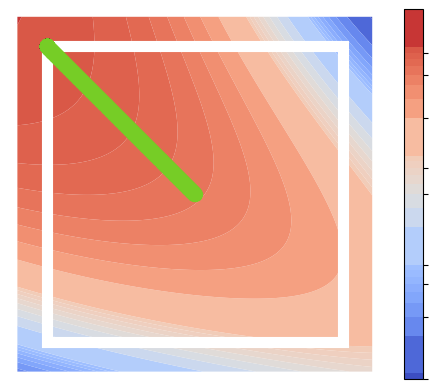

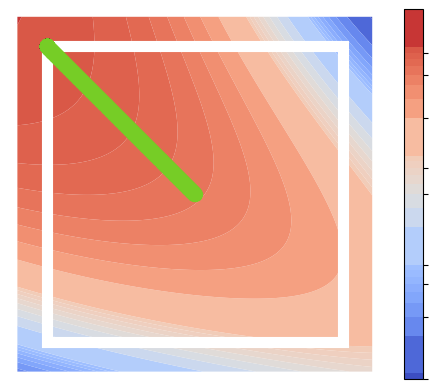

In [7]:
a = [-0.3214, -0.5019] #[0.9425, 0.4066] # [ -0.8411, -0.9329]
x0 = torch.tensor(a, device=device)[None,:]

hs = run_iterations(x0, [0.001])
plot_iterations(hs, colorbar=True)